In [45]:
from langchain_ollama import OllamaEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_community.utilities import SQLDatabase
import pandas as pd
import sqlite3
import ast
import re

In [7]:
# 데이터베이스 생성
conn = sqlite3.connect("etf_database.db")
cursor = conn.cursor()

In [8]:
etfs = pd.read_csv("data/etf_list.csv", encoding="cp949")

etfs.head(3)

etfs.rename(columns={"수익률(최근 1년)" : "수익률_최근1년"},inplace=True)

In [ ]:
cursor.execute("""
    CREATE TABLE ETFs(
        종목코드 TEXT PRIMARY KEY,
        종목명 TEXT,
        상장일 TEXT,
        분류체계 TEXT,
        운용사 TEXT,
        수익률_최근1년 REAL,
        기초지수 TEXT,
        추적오차 REAL,
        순자산총액 REAL,
        괴리율 REAL,
        변동성 TEXT,
        복제방법 TEXT,
        총보수 REAL,
        과세유형 TEXT
        )
""")

In [ ]:
for idx,row in etfs.iterrows():
        cursor.execute(
            "INSERT INTO ETFs VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?)",
            (
                str(row['종목코드']),
                str(row['종목명']),
                str(row['상장일']),
                str(row['분류체계']),
                str(row['운용사']),
                float(row['수익률_최근1년']) if not pd.isna(row['수익률_최근1년']) else None,
                str(row['기초지수']),
                float(row['추적오차'])  if not pd.isna(row['추적오차']) else None,
                float(row['순자산총액'])  if not pd.isna(row['순자산총액']) else None,
                str(row['괴리율']),
                str(row['변동성']),
                str(row['복제방법']),
                float(row['총보수'])  if not pd.isna(row['총보수']) else None,
                str(row['과세유형']),
            ))

conn.commit()

In [43]:
conn.close()

In [ ]:

db = SQLDatabase.from_uri("sqlite:///etf_database.db")

sqlite


In [55]:
# 사용 엔진
print(db.dialect)

print(db.get_usable_table_names())

etfs = db.run("SELECT * FROM ETFs LIMIT 5;")

for etf in eval(etfs):
    print(etf)

sqlite
['ETFs']
('466400', '1Q 25-08 회사채(A+이상)액티브', '2023/09/19', '채권-회사채-단기', '하나자산운용', 4.52, 'KIS 2025-08만기형 크레딧 A+이상 지수(총수익)', 0.11, 111916276404.0, 0.03, '매우낮음', '실물(액티브)', 0.1, '배당소득세(보유기간과세)')
('491610', '1Q CD금리액티브(합성)', '2024/09/24', '기타', '하나자산운용', 0.0, 'KIS 하나 CD금리 총수익지수', 0.05, 316206006696.0, 0.02, '매우낮음', '합성(액티브)', 0.02, '배당소득세(보유기간과세)')
('451060', '1Q K200액티브', '2023/01/31', '주식-시장대표', '하나자산운용', -3.66, '코스피 200', 0.77, 99754348820.0, -0.01, '높음', '실물(액티브)', 0.18, '배당소득세(보유기간과세)')
('463290', '1Q 단기금융채액티브', '2023/08/03', '채권-혼합-단기', '하나자산운용', 4.01, 'MK 머니마켓 지수(총수익)', 0.05, 252717462257.0, 0.0, '매우낮음', '실물(액티브)', 0.08, '배당소득세(보유기간과세)')
('479080', '1Q 머니마켓액티브', '2024/04/02', '채권-혼합-단기', '하나자산운용', 0.0, 'KIS-하나 MMF 지수(총수익)', 0.06, 308255065986.0, -0.01, '매우낮음', '실물(액티브)', 0.05, '배당소득세(보유기간과세)')


In [1]:
from langchain_openai import ChatOpenAI
from langchain import hub
from dotenv import load_dotenv

load_dotenv()

True

In [5]:
llm = ChatOpenAI(model="gpt-4o-mini")

query_prompt_template = hub.pull("langchain-ai/sql-query-system-prompt")

assert len((query_prompt_template.messages)) == 1
query_prompt_template.messages[0].pretty_print()

================================ System Message ================================

Given an input question, create a syntactically correct {dialect} query to run to help find the answer. Unless the user specifies in his question a specific number of examples they wish to obtain, always limit your query to at most {top_k} results. You can order the results by a relevant column to return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema description. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.

Only use the following tables:
{table_info}

Question: {input}


In [6]:
query_prompt_template.input_schema.model_json_schema()

{'properties': {'dialect': {'title': 'Dialect', 'type': 'string'},
  'input': {'title': 'Input', 'type': 'string'},
  'table_info': {'title': 'Table Info', 'type': 'string'},
  'top_k': {'title': 'Top K', 'type': 'string'}},
 'required': ['dialect', 'input', 'table_info', 'top_k'],
 'title': 'PromptInput',
 'type': 'object'}

In [8]:
from typing import Annotated ,TypedDict

class QueryOutput(TypedDict):
    query : Annotated[str,...,"syntactically valid SQL query"]


class State(TypedDict):
    question: str  # 입력 질문
    query: str     # 생성된 쿼리
    result: str    # 쿼리 결과
    answer: str    # 생성된 답변

In [9]:
def write_query(state : State):
    prompt = query_prompt_template.invoke(
        {
            "dialect" : db.dialect,
            "top_k" : 10,
            "table_info" : db.get_table_info(),
            "input" : state["question"]
        }
    )
    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    return {"query" : result["query"]}

In [10]:
from langchain_community.tools import QuerySQLDatabaseTool

def execute_query(state : State):
    execute_query_tool = QuerySQLDatabaseTool(db=db)
    return {"result" : execute_query_tool.invoke(state["query"])}

In [12]:
def generate_answer(state : State):
    prompt = {
        "Given the follwing user question, corresponding SQL query,"
        "and SQL result, answer the user question\n\n"
        f"Question : {state['question']}"
        f"SQL Query : {state['query']}"
        f"SQL Result : {state['result']}"
    }
    response = llm.invoke(prompt)
    return {"answer" : response.content}

In [13]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence(
    [write_query, execute_query, generate_answer]
)

graph_builder.add_edge(START, "write_query")
graph = graph_builder.compile()

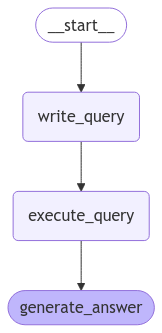

In [17]:
from IPython.display import Image, display

(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
embedding = OllamaEmbeddings(model="bge-m3:latest")
vector_store = InMemoryVectorStore(
    embedding=embedding
)

for res in result_name+result_corp:
    _ = vector_store.add_texts(res)
retriever = vector_store.as_retriever(
    search_type = "mmr",
    search_kwargs = {'k' : 5}
)

KeyboardInterrupt: 

In [35]:
retriever.invoke("KB가 운용하는 종목은?")

[Document(id='121c4a4a-f58b-44b2-94c1-e957d339940a', metadata={}, page_content='케이비자산운용'),
 Document(id='e8d784ea-59a2-44bd-8311-3554e99b36a4', metadata={}, page_content='케이비자산운용'),
 Document(id='6dbf18f3-89ac-4af6-8f56-7a89415f6777', metadata={}, page_content='케이비자산운용'),
 Document(id='04888fc4-4314-478e-9754-436b1780085e', metadata={}, page_content='케이비자산운용'),
 Document(id='1229294a-6f83-471e-9e15-370c6a016f9d', metadata={}, page_content='케이비자산운용')]